# Data Exploration and Cleaning

In [1]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv('./data/medium_data.csv')
df.set_index('id', inplace=True)

In [3]:
df.head()

,url,title,subtitle,image,claps,responses,reading_time,publication,date
id,,,,,,,,,
1,https://towardsdatascience.com/a-beginners-gui...,A Beginner’s Guide to Word Embedding with Gens...,NaN,1.png,850,8,8,Towards Data Science,2019-05-30
2,https://towardsdatascience.com/hands-on-graph-...,Hands-on Graph Neural Networks with PyTorch & ...,NaN,2.png,1100,11,9,Towards Data Science,2019-05-30
3,https://towardsdatascience.com/how-to-use-ggpl...,How to Use ggplot2 in Python,A Grammar of Graphics for Python,3.png,767,1,5,Towards Data Science,2019-05-30
4,https://towardsdatascience.com/databricks-how-...,Databricks: How to Save Files in CSV on Your L...,When I work on Python projects dealing…,4.jpeg,354,0,4,Towards Data Science,2019-05-30
5,https://towardsdatascience.com/a-step-by-step-...,A Step-by-Step Implementation of Gradient Desc...,One example of building neural…,5.jpeg,211,3,4,Towards Data Science,2019-05-30


In [4]:
df.count()

url             6508
title           6508
subtitle        3479
image           6361
claps           6508
responses       6508
reading_time    6508
publication     6508
date            6508
dtype: int64

In [5]:
df.publication.unique()

array(['Towards Data Science', 'UX Collective', 'The Startup',
       'The Writing Cooperative', 'Data Driven Investor',
       'Better Marketing', 'Better Humans'], dtype=object)

Since these are all different websites it could be useful to treat them as different datasets, or at least see the difference if models are trained site-wise or medium-wise.

Let's explore claps based on the different publications

In [6]:
df.dtypes

url             object
title           object
subtitle        object
image           object
claps            int64
responses       object
reading_time     int64
publication     object
date            object
dtype: object

There is some problem with the dataset: responsens should be an integer type it's an object, let's check why

In [7]:
responses = df.responses

In [8]:
# First attempt (reference)
"""
for idx, n_responses in responses:
    
    if(not n_responses.isnumeric()):
        print(n_responses)
        print(idx)
"""

# Cleaner solution
query = df.apply(lambda row: not row['responses'].isnumeric(), axis=1)

df[query]

,url,title,subtitle,image,claps,responses,reading_time,publication,date
id,,,,,,,,,
3978,https://medium.com/datadriveninvestor/what-do-...,What do you think of the Open Group’s Data Sci...,NaN,3978.jpg,73,Read,3,Data Driven Investor,2019-05-24
6393,https://uxdesign.cc/please-please-please-tell-...,"UX doesn’t discriminate, it targets behaviours",NaN,NaN,74,Read,5,UX Collective,2019-12-05


As we have a lot of articles in the dataset, we can stay conservatives and remove these two rows

In [9]:
df = df[~query]

In [10]:
df.count()

url             6506
title           6506
subtitle        3479
image           6360
claps           6506
responses       6506
reading_time    6506
publication     6506
date            6506
dtype: int64

In [11]:
df.dtypes

url             object
title           object
subtitle        object
image           object
claps            int64
responses       object
reading_time     int64
publication     object
date            object
dtype: object

The responses column is still of generic type object, we need to convert it

In [12]:
df['responses'] = df['responses'].astype(int)
df.dtypes

url             object
title           object
subtitle        object
image           object
claps            int64
responses        int64
reading_time     int64
publication     object
date            object
dtype: object

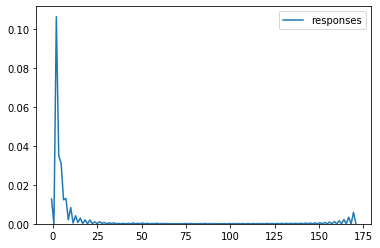

In [13]:
sns.kdeplot(df.responses)

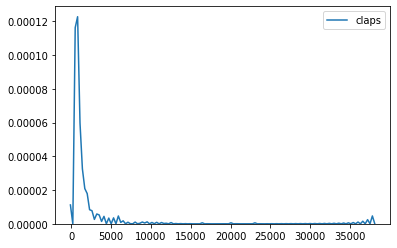

In [14]:
sns.kdeplot(df.claps)

We can see that the distribution of both claps and responses is quite similar and we can expect high correlation between the two columns

In [15]:
df['claps'].corr(df['responses'])

0.8387083748257861

As expected, the problem is that we can't use responses to predict claps because, as you can expect, they both happen after the post is online and we need to predict how the post will perform before we even publish it.

The task descriptions says that we need to predict claps based on title, subtitle and front image but why should we miss on the other valid data?

For example we can use reading time (as it is calculated by Medium while the post is still a draft) and we can also generate features based on publishing date (like month, quarter of the year, day of the week etc..)

Also if the model we will write is general for medium, we can even use publication as a predictor

Let's check how much correlated is reading_time with claps:

In [16]:
df['claps'].corr(df['reading_time'])

0.07423747336514576

The correlation of reading_time and claps is really low, but there is some effect. One hypothesis could be that user that read an article for longer could click claps more times during the reading.

It is interesting to check if the effect is different by publication (as the readers are from different domains)

In [17]:
for publication in df.publication.unique():
    pub_df = df[df['publication'] == publication]
    print("{} has {} articles".format(publication, pub_df.shape[0]))
    

Towards Data Science has 1461 articles
UX Collective has 554 articles
The Startup has 3041 articles
The Writing Cooperative has 403 articles
Data Driven Investor has 777 articles
Better Marketing has 242 articles
Better Humans has 28 articles


The number of articles they all seem sufficient for experimentation, just Better Humans seems to not have enough of them.

In [18]:
for publication in df.publication.unique():
    pub_df = df[df['publication'] == publication]
    corr = pub_df['claps'].corr(pub_df['reading_time'])
    print("{} has {} correlation between claps and reading_time ".format(publication, corr))

Towards Data Science has 0.15554793532294087 correlation between claps and reading_time 
UX Collective has 0.15056143188578966 correlation between claps and reading_time 
The Startup has 0.015584638910618216 correlation between claps and reading_time 
The Writing Cooperative has 0.033461778166128046 correlation between claps and reading_time 
Data Driven Investor has 0.1750898540449691 correlation between claps and reading_time 
Better Marketing has 0.08595599268513456 correlation between claps and reading_time 
Better Humans has -0.04049860498109845 correlation between claps and reading_time 


Interesting, all the "computer science" oriented websites have higher correlation between reading time and claps

Let's save the new dataframe for future use.

In [19]:
df.to_csv('data/cleaned.csv')

# Problem tackling hypothesis

The problem is a regression problem but it is not setup as a classical machine learning problem.
It merges up to 3 areas (based on what features one wants to use), the main areas are the following:

- Tabular data: For everything relative to reading time and date
- NLP: to generate features for the ML algorithms
- Deep learning vision: to use images as predictors of claps

The idea is that to use NLP to generate features and add them to the dataset and using classical ML regression algorithms (linear regression, decision trees, gradient boosted trees etc...).
Then create a deep learning module that can calculate the same regression using only images, in the end using some ensemble or weighted average to give the final result.

If the regression using images is too difficult another test could be that of binning claps and trasforming everything to a classification problem and add the result as a feature for tabular data.